# Generative Adversarial Networks (GANs) Training Demo

## Imports

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle as pkl
from torchview import draw_graph


## Hyperparameters

In [16]:
batch_size = 64
latent_dim = 100
learning_rate = 0.0002
epochs = 100

## Load the MNIST dataset

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize [-1, 1]
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Generator

In [18]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.5),
            nn.Linear(512, 28*28),
            nn.BatchNorm1d(28*28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

## Discriminator

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity


## Initialize the GAN

In [20]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


## Training

Epoch [0], D_loss: 0.0641, G_loss: 25.9130


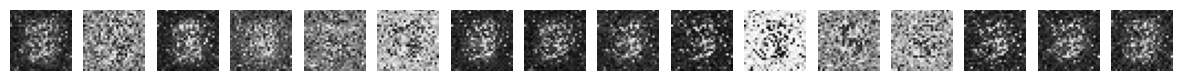

Epoch [10], D_loss: 0.6925, G_loss: 8.0953


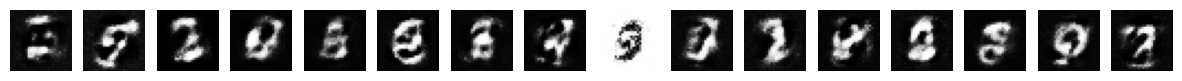

Epoch [20], D_loss: 1.0040, G_loss: 1.5513


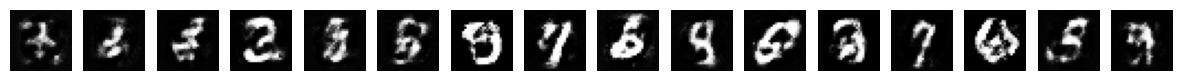

Epoch [30], D_loss: 1.0594, G_loss: 1.1506


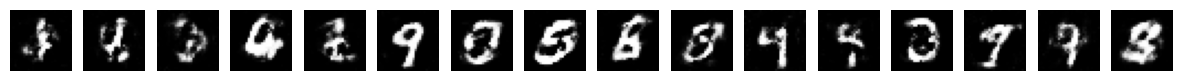

Epoch [40], D_loss: 1.1117, G_loss: 1.1889


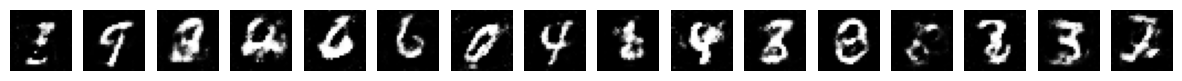

Epoch [50], D_loss: 1.0739, G_loss: 1.4789


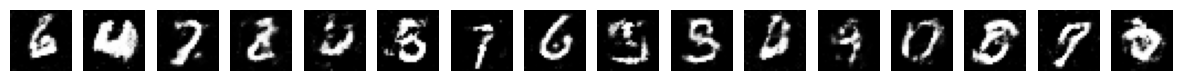

Epoch [60], D_loss: 0.9799, G_loss: 1.0000


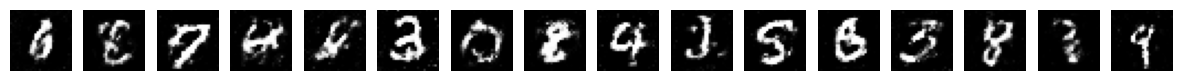

Epoch [70], D_loss: 0.9552, G_loss: 1.0336


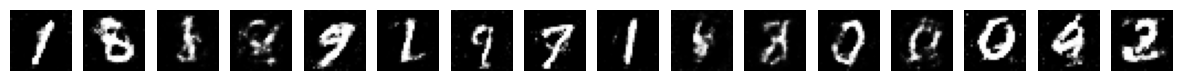

Epoch [80], D_loss: 0.9457, G_loss: 1.3014


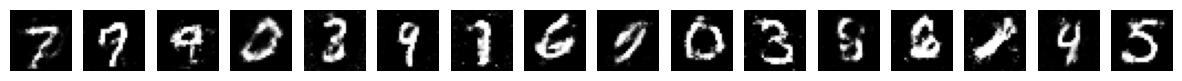

Epoch [90], D_loss: 1.0577, G_loss: 1.1913


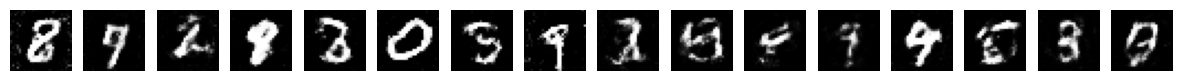

In [21]:
# Initialize lists to track losses
D_losses = []
G_losses = []

for epoch in range(epochs):
    for i, (images, _) in enumerate(train_loader):
        # Flatten the images for the Discriminator
        images = images.view(images.size(0), -1).to(device)

        # Real labels are 1, fake labels are 0
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        ############################
        # Train the Discriminator
        ############################
        optimizer_D.zero_grad()

        # Compute BCELoss using real images
        outputs = discriminator(images).to(device)
        D_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Generate fake images
        z = torch.randn(images.size(0), latent_dim).to(device)
        fake_images = generator(z).to(device)

        # Compute BCELoss using fake images
        outputs = discriminator(fake_images.detach())
        D_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Optimize the Discriminator
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()
        optimizer_D.step()

        ############################
        # Train the Generator
        ############################
        optimizer_G.zero_grad()

        # Generate fake images
        z = torch.randn(images.size(0), latent_dim).to(device)
        fake_images = generator(z).to(device)

        # Compute BCELoss using fake images, with reversed labels
        outputs = discriminator(fake_images).to(device)
        G_loss = criterion(outputs, real_labels)

        # Optimize the Generator
        G_loss.backward()
        optimizer_G.step()

    # Append losses for plotting
    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())

    # Log the losses
    if epoch % 10 == 0:
        print('Epoch [{}], D_loss: {:.4f}, G_loss: {:.4f}'
              .format(epoch, D_loss.item(), G_loss.item()))

        # Generate and visualize some fake images
        fake_images = generator(z)
        fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
        fake_images = (fake_images + 1) / 2
        fig, axes = plt.subplots(1, 16, figsize=(15, 15))
        for ax, img in zip(axes.flatten(), fake_images):
            ax.axis('off')
            ax.set_adjustable('box')
            img = transforms.ToPILImage()(img.cpu().squeeze())
            ax.imshow(img, cmap='gray')
        plt.show()


## Plot losses

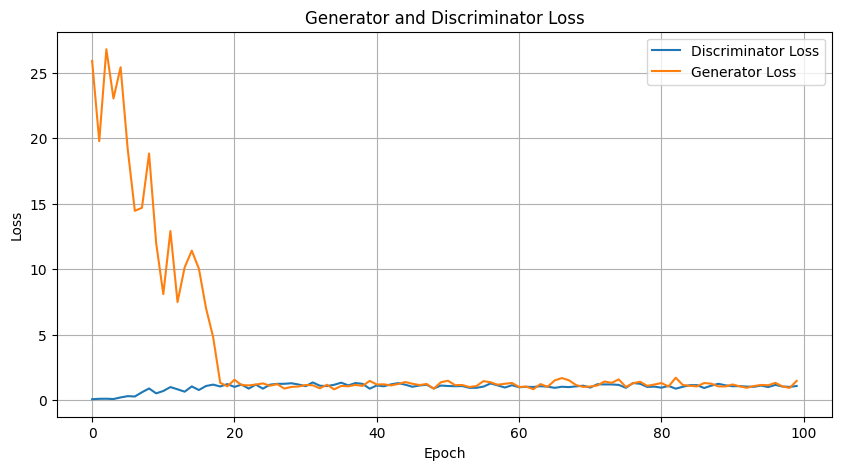

In [22]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(D_losses, label="Discriminator Loss")
plt.plot(G_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Loss")
plt.legend()
plt.grid(True)
plt.savefig('./images/gan_losses.png')
plt.show()

## Store models

In [23]:
with open('./pickle/generator.pkl', 'wb') as file:
    pkl.dump(generator, file)
with open('./pickle/discriminator.pkl', 'wb') as file:
    pkl.dump(generator, file)

## Draw model graphs

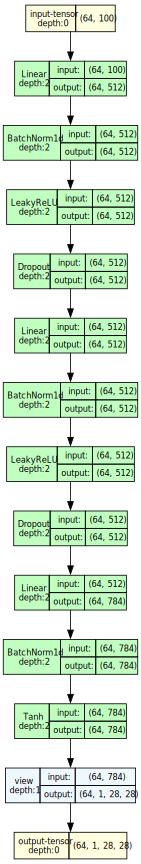

In [24]:
generator_model_graph = draw_graph(generator, torch.randn(batch_size, latent_dim), device='meta', save_graph=True, filename='generator_model_graph', directory='./images')
generator_model_graph.visual_graph

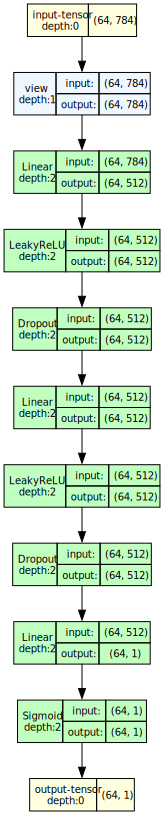

In [25]:
discriminator_model_graph = draw_graph(discriminator, torch.randn(batch_size, 28*28), device='meta', save_graph=True, filename='discriminator_model_graph', directory='./images')
discriminator_model_graph.visual_graph